In [5]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import scipy.integrate as integrate
from __future__ import unicode_literals
from sklearn import preprocessing as prep
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.mixture import GaussianMixture as gm
from multiprocessing import Pool
from sklearn.cluster import KMeans

In [655]:
class LOB:
    def __init__(self, wiersz):
        self.zmiana = 0
        self.dzien = int(wiersz[0]) % 100
        self.czas = int(wiersz[1])
        i = 3
        while (wiersz[i] != 'ASK'):
            i += 1
        bid = wiersz[3:i]
        ask = wiersz[(i+1):]
        self.bid = np.zeros((int((len(bid) / 2)), 2))
        self.ask = np.zeros((int((len(ask) / 2)), 2))
        for i in range(0, len(bid), 2):
            self.bid[int(i / 2)][0] = float(bid[i]) 
            self.bid[int(i / 2)][1] = float(bid[i+1])
        for i in range(0, len(ask), 2):
            self.ask[int(i / 2)] = [float(ask[i]), float(ask[i+1])]
        self.midPrice = (self.bid[len(self.bid) - 1][0] + self.ask[0][0]) / 2
    def __str__(self):
        return "Dzień: " + self.dzien + ", Czas: " + self.czas + ", midPrice: " + str(self.midPrice)

def generujZmiane(X):
    for i in range(len(X) - 1):
        if (X[i].midPrice < X[i + 1].midPrice):
            X[i].zmiana = 1
        if (X[i].midPrice > X[i + 1].midPrice):
            X[i].zmiana = -1
        if (X[i].midPrice == X[i + 1].midPrice):
            X[i].zmiana = 0
    return np.array([i.zmiana for i in X])

def czas(h, m):
    mnoznikM = 100000
    mnoznikH = 10000000
    return h*mnoznikH + m*mnoznikM

def czasOdwrotny(x):
    mnoznikM = 100000
    mnoznikH = 10000000
    return (int(x / mnoznikH), int((x % mnoznikH) / mnoznikM))

def generujPozycje(x):
    pozLewa = (x.bid[-1][0] - minimum ) * 10
    pozPrawa = (x.ask[0][0] - minimum ) * 10
    pozLewaInt = int(np.round(pozLewa))
    pozPrawaInt = int(np.round(pozPrawa))
    return (pozLewaInt, pozPrawaInt)

def generujPrzedzialy(x, ilosc, f):
    pozLewa, pozPrawa = generujPozycje(x)
    przedzialy = []
    wspXowe = []
    for i in range(ilosc):
        fi = f(i)
        wspXowe.append((pozPrawa / 10) + minimum + (fi / 2))
        wspXowe.append((pozLewa / 10) + minimum - (fi / 2))
        fi10 = int(np.floor(fi*10))
        tmpList = np.arange(fi10)
        przedzialy.append(pozPrawa + tmpList)
        pozPrawa += fi10
        pozLewa -= fi10
        przedzialy.append(pozLewa + 1 + tmpList)
    return przedzialy, wspXowe
        
def generujTabliceTickow(tablica, X, ilosc, f):
    wynik = np.zeros((len(X), 2 * ilosc))
    listaWspXowych = []
    for i in range(len(X)):
        wiersz = tablica[i]
        przedzialy, wspXowe = generujPrzedzialy(X[i], ilosc, f)
        listaWspXowych.append(wspXowe)
        for j in range(2 * ilosc):
            przedzial = przedzialy[j]
            przedzial = przedzial[przedzial >= 0]
            przedzial = przedzial[przedzial < liczbaWspolrzednych]
            wynik[i][j] = np.sum(wiersz[przedzial])
    return wynik, listaWspXowych

def narysujPrzykladowyWykres(xAsk, yAsk, xBid, yBid, midPrice, nawa, sizex = 8, sizey = 4, zblizone = False):
    plt.rc('font', family='Arial')
    plt.rcParams["figure.figsize"] = [sizex, sizey]
    maks = np.max([np.max(yBid), np.max(yAsk)])
    plt.xlabel('Cena')
    plt.ylabel("Ilość")
    szerokosc = 0.2
    if (zblizone):
        plt.xticks(np.arange(midPrice - 12, midPrice + 12, 2))
        lewe = midPrice - 8
        prawe = midPrice + 8
        maks = np.max([np.max(yBid[xBid >= lewe]), np.max(yAsk[xAsk <= prawe])])
        plt.axis([lewe, prawe, 0, maks])
        szerokosc /= 10
    else:
        plt.xticks(np.arange(midPrice-75, midPrice+125, 25))
        plt.axis([midPrice-75, midPrice+100, 0, maks])
    plt.title("Ilość akcji w stosunku do ceny")
    
    plt.bar(xBid, yBid, width=szerokosc, color = 'blue', edgecolor = "blue", label = "BID")
    plt.bar(xAsk, yAsk, width=szerokosc, color = 'red', edgecolor = "red", label = "ASK")
    
    plt.bar(midPrice, maks, width=szerokosc, color = 'green', edgecolor = "green", label = "mid-price")

    plt.legend()

    plt.tight_layout()
    plt.savefig(nawa)
    plt.show()

def generujImbalance(X):
    i = 0
    Imbalance = np.zeros((X.shape[0], 1))
    for wiersz in X: 
        bid = wiersz.bid[-1, 1]
        ask = wiersz.ask[0, 1]
        Imbalance[i] = (bid - ask) / (bid + ask)
        i += 1
    return Imbalance

In [301]:
daneS = 'OrderBookSnapshots.csv';
with open(daneS, 'r') as f:
    dane = f.readlines()
X = []
for wiersz in dane:
    newWiersz = wiersz.split()
    X.append(LOB(newWiersz))
X = np.array(X)
zmiana = generujZmiane(X)

In [302]:
print ("Ilość danych:", len(X))

Ilość danych: 5474


In [304]:
iloscBlednychDanych = np.sum(np.array([(wiersz.bid[-1][0] > wiersz.ask[0][0]) for wiersz in X]))
print("ilość błędnych danych:", iloscBlednychDanych)

ilość błędnych danych: 150


In [322]:
print("dzień    ilość danych")
for k in range(0, 17):
    maska = np.array([(wiersz.dzien == k) for wiersz in X])
    ilosc = np.sum(maska)
    print(k, "      ", ilosc)

dzień    ilość danych
0        0
1        1
2        545
3        547
4        545
5        550
6        549
7        0
8        0
9        548
10        549
11        546
12        548
13        546
14        0
15        0
16        0


In [306]:
listaDni = np.array([2, 3, 4, 5, 6, 9, 10, 11, 12 ,13])

In [307]:
procenty = np.zeros((14, 24))
maska
for k in listaDni:
    maska = np.array([(wiersz.dzien == k) for wiersz in X])
    ilosc = np.max([np.sum(maska), 1])
    for i in range(24):
        procenty[k-1][i] = (np.sum([(wiersz.czas >= czas(i, 0) and wiersz.czas < czas(i+1,0)) for wiersz in X[maska]]) / ilosc * 100)
        
wiersz = ''
wynikProcentow = np.sum(procenty[(listaDni-1)], axis = 0) / 10
for i in range(6, 20):
    print('{0}-{1}:  {2:.2f}%  '.format(i, i+1, wynikProcentow[i]))

6-7:  0.00%  
7-8:  1.64%  
8-9:  10.96%  
9-10:  10.96%  
10-11:  10.96%  
11-12:  10.96%  
12-13:  10.96%  
13-14:  10.96%  
14-15:  10.96%  
15-16:  10.96%  
16-17:  9.88%  
17-18:  0.58%  
18-19:  0.16%  
19-20:  0.00%  


In [308]:
maskaCzasu = np.array([wiersz.czas > czas(8, 0) and wiersz.czas < czas(16, 45) for wiersz in X])
listaGdzieBylyZmiany = np.arange(len(X))[np.array([(i.zmiana != 0) for i in X])]
indeksy = []
for indeks in listaGdzieBylyZmiany:
    if (maskaCzasu[indeks]):
        indeksy.append(indeks)
indeksy = np.array(indeksy)

In [309]:
iloscBlednychDanych = np.sum(np.array([(wiersz.bid[-1][0] > wiersz.ask[0][0]) for wiersz in X[maskaCzasu]]))
print("ilość błędnych danych:", iloscBlednychDanych)

ilość błędnych danych: 50


In [325]:
maskaCzasu = np.array([wiersz.czas > czas(8, 0) and wiersz.czas < czas(16, 30) for wiersz in X])
listaGdzieBylyZmiany = np.arange(len(X))[np.array([(i.zmiana != 0) for i in X])]
indeksy = []
for indeks in listaGdzieBylyZmiany:
    if (maskaCzasu[indeks]):
        indeksy.append(indeks)
indeksy = np.array(indeksy)

In [332]:
iloscBlednychDanych = np.sum(np.array([(wiersz.bid[-1][0] > wiersz.ask[0][0]) for wiersz in X[maskaCzasu]]))
print("ilość błędnych danych:", iloscBlednychDanych)

ilość błędnych danych: 0


In [333]:
print("Procent danych ograniczonych do przedziału od 8:00 do 16:30: {0:.2f}%".format(100*np.sum(maskaCzasu) / len(X)))

Procent danych ograniczonych do przedziału od 8:00 do 16:30: 92.99%


In [343]:
print("Pozbyliśmy się: {0} danych".format(len(X) - np.sum(maskaCzasu)))

Pozbyliśmy się: 384 danych


In [339]:
print("Ilość l(t), w których z(t) != 0: {0}".format(len(listaGdzieBylyZmiany)))
print("Procent l(t), w których z(t) != 0: {0:.2f}%".format(100*len(listaGdzieBylyZmiany) / len(X)))

Ilość l(t), w których z(t) != 0: 4652
Procent l(t), w których z(t) != 0: 84.98%


In [340]:
print("Ilość l(t), w których z(t) != 0: {0}".format(len(indeksy)))
print("Procent l(t) ograniczonych do przedziału czasowego, w których z(t) != 0: {0:.2f}%".format(100*len(indeksy) / len(X)))

Ilość l(t), w których z(t) != 0: 4588
Procent l(t) ograniczonych do przedziału czasowego, w których z(t) != 0: 83.81%


In [336]:
print("Procent l(t), w których z(t) != 0 ograniczonych do przedziału czasowego w porównaniu do tych nie ograniczonych: {0:.2f}%".format(100*len(indeksy) / len(listaGdzieBylyZmiany)))

Procent l(t), w których z(t) != 0 ograniczonych do przedziału czasowego w porównaniu do tych nie ograniczonych: 98.62%


In [344]:
X = X[indeksy]

In [345]:
print("Ilość danych po redukcjach:", len(X))

Ilość danych po redukcjach: 4588


In [348]:
zmiana = generujZmiane(X)

In [351]:
print("Ilość danych, w których z(t) = 1: {0}".format(np.sum(zmiana == 1)) )
print("procent l(t), w których z(t) = 1: {0:.2f}%".format(100*np.sum(zmiana == 1) / len(X)) )

Ilość danych, w których z(t) = 1: 2292
procent l(t), w których z(t) = 1: 49.96%


In [353]:
print("Ilość danych, w których z(t) = -1: {0}".format(np.sum(zmiana == -1)) )
print("procent l(t), w których z(t) = -1: {0:.2f}%".format(100*np.sum(zmiana == -1) / len(X)) )

Ilość danych, w których z(t) = -1: 2296
procent l(t), w których z(t) = -1: 50.04%


In [379]:
minimum = 100000
maksimum = 0
for wiersz in X:
    bid = wiersz.bid[0, 0]
    ask = wiersz.ask[-1, 0]
    if(ask > maksimum):
        maksimum = ask
    if(bid < minimum):
        minimum = bid 
liczbaWspolrzednych = int((maksimum - minimum) * 10 + 1)

In [380]:
print("minimum: {0}, maksimum: {1}".format(minimum, maksimum))

minimum: 494.0, maksimum: 900.0


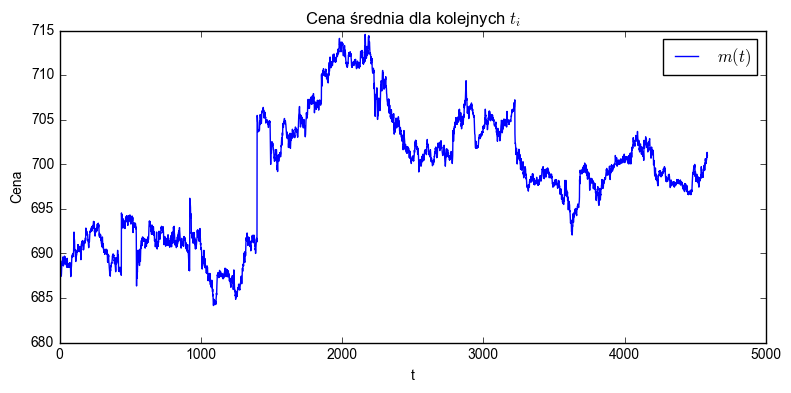

In [376]:
plt.rc('font', family='Arial')
plt.rcParams["figure.figsize"] = [8, 4]
plt.title("Cena średnia dla kolejnych $t_i$")
plt.xlabel('t')
plt.ylabel("Cena")
kolejneCzasy = np.arange(len(X))
kolejneMidPrice = np.array([wiersz.midPrice for wiersz in X])
plt.plot(kolejneCzasy, kolejneMidPrice, label = "$m(t)$")
plt.legend()
plt.tight_layout()
plt.savefig("CenaKolejnychMidPrice")
plt.show()

In [418]:
nrWiersza = 2300
midPrice = X[nrWiersza].midPrice

In [538]:
tablica = np.zeros((len(X), liczbaWspolrzednych), dtype=int)
i = 0
for wiersz in X:
    for item in wiersz.bid:
        tablica[i][int(np.round((item[0] - minimum)*10))] = int(np.round(-item[1]))
    for item in wiersz.ask:
        tablica[i][int(np.round((item[0] - minimum)*10))] = int(np.round(item[1]))
    i += 1

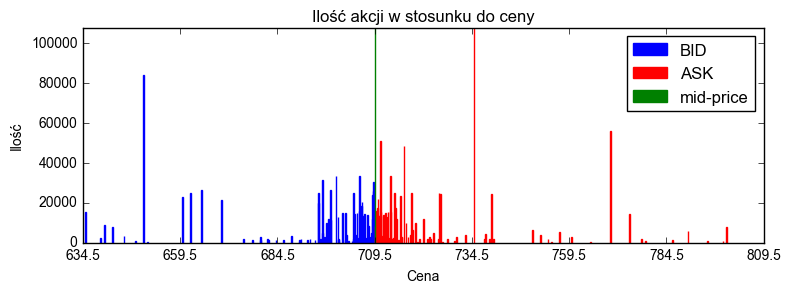

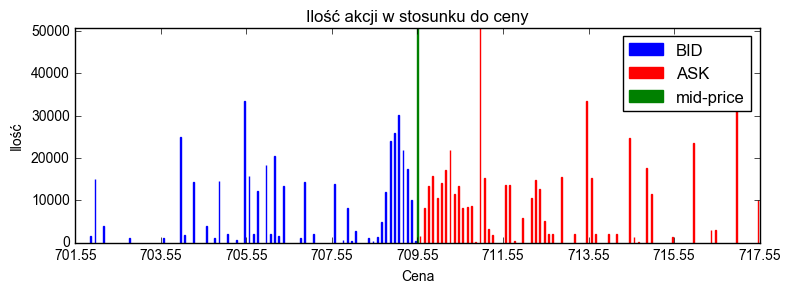

In [539]:
wiersz = X[nrWiersza]
narysujPrzykladowyWykres(wiersz.ask[:, 0], wiersz.ask[:, 1], wiersz.bid[:, 0], wiersz.bid[:, 1],
                         midPrice, "PrzykladDanychDlaListyLobow", 8, 3)
narysujPrzykladowyWykres(wiersz.ask[:, 0], wiersz.ask[:, 1], wiersz.bid[:, 0], wiersz.bid[:, 1],
                         midPrice, "PrzykladDanychDlaListyLobowPrzyblizony", 8, 3, True)

In [586]:
tablicaTickowPo1, tablicaTickowPo1Wsp = generujTabliceTickow(tablica, X, 200, lambda x: 1)

In [597]:
np.sum([(.1 if (i < 2) else np.log2(i)/10) for i in range(200)]), np.sum([funkcjaPrzedzialow(i) for i in range(34)])

(123.97366508694338, 138.20000000000002)

In [618]:
np.sum([(.1 if (i < 2) else np.log2(i)/10) for i in range(200)]), np.sum([funkcjaPrzedzialow(i) for i in range(32)])

(123.97366508694338, 119.0)

In [611]:
lista = [(.1 if (i < 1) else np.log2(i + 1)/10) for i in range(200)]

In [613]:
lista = np.array(lista)

In [592]:
np.log2(1), funkcjaPrzedzialow(1)

(0.0, 0.2)

In [541]:
def funkcjaPrzedzialow(i):
    return (int((0.1 + (0.05 + i / 20) * np.sqrt(i)) * 10) / 10)

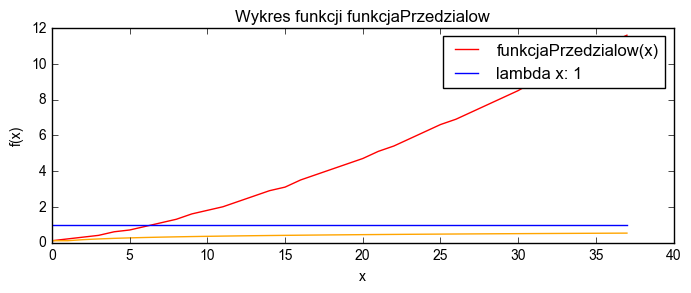

In [615]:
plt.rcParams["figure.figsize"] = [7, 3]
dl = 38
plt.plot(np.arange(dl), [funkcjaPrzedzialow(i) for i in range(dl)], color = "red", label = "funkcjaPrzedzialow(x)")
plt.plot(np.arange(dl), [1 for i in range(dl)], color = "blue", label = "lambda x: 1")
plt.plot(np.arange(dl), [(.1 if (i < 1) else np.log2(i + 1)/10) for i in range(dl)], color='orange')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Wykres funkcji funkcjaPrzedzialow")

plt.legend()

plt.tight_layout()
plt.show()

In [621]:
tablicaTickowRosnaca, tablicaTickowRosnacaWsp = generujTabliceTickow(tablica, X, 32, funkcjaPrzedzialow)

In [ ]:
(.1 if (i < 1) else np.log2(i + 1)/10)

In [620]:
tablicaTickowLogarytmiczna, tablicaTickowLogarytmicznaWsp = generujTabliceTickow(tablica, X, 200, lambda i: (.1 if (i < 1) else np.log2(i + 1)/10))

In [675]:
def standaryzowanie(tab):
    tabS = prep.StandardScaler().fit_transform(tab)
    tabN = prep.Normalizer().fit_transform(tab)
    tabSN = prep.Normalizer().fit_transform(tabS)
    tabNS = prep.StandardScaler().fit_transform(tabN)
    return tab, tabS, tabN, tabSN, tabNS

def zwrocDzien(x):
    return {
        0 : 'poniedziałek',
        1 : 'wtorek',
        2 : 'środa',
        3 : 'czwartek',
        4 : 'piątek'
    }[x % 5]

def test2( nazwa, tablica, tablica2, tablica3, tablica4, tablica5, svm, ilosc = 4, procent = 0.75, iloscKolumn = 200):
    wynik1 = crossValidationPoKolei(svm, (((tablica).T[:iloscKolumn]).T), zmiana, ilosc, procent)
    wynik2 = crossValidationPoKolei(svm, (((tablica2).T[:iloscKolumn]).T), zmiana, ilosc, procent)
    wynik3 = crossValidationPoKolei(svm, (((tablica3).T[:iloscKolumn]).T), zmiana, ilosc, procent)
    wynik4= crossValidationPoKolei(svm, (((tablica4).T[:iloscKolumn]).T), zmiana, ilosc, procent) 
    wynik5 = crossValidationPoKolei(svm, (((tablica5).T[:iloscKolumn]).T), zmiana, ilosc, procent) 
    return wynik1, wynik2, wynik3, wynik4, wynik5


def wypisz(TAB, liczbaKolumn = 200):
    tab, tabS, tabN, tabSN, tabNS = standaryzowanie(TAB)
    gammas = [1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6]
    Cs = [1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6]

    procent = 0.7
    print("procent =", procent)
    print('Czyste  S     N     S->N    N->S')
    for gamma in gammas:
        for C in Cs:
            svm = SVC(class_weight='balanced', gamma = gamma, kernel = 'rbf', C = C)
            wynik1, wynik2, wynik3, wynik4, wynik5 = test2("imbalance", tab, tabS, tabN, tabSN, tabNS, svm, ilosc = 4, procent = procent, iloscKolumn = liczbaKolumn)
            odpowiedz = "{0:0.4f}  {1:0.4f}  {2:0.4f}  {3:0.4f}  {4:0.4f}".format(wynik1, wynik2, wynik3, wynik4, wynik5)
            if (wynik1 > 0.52 or wynik2 > 0.52 or wynik3 > 0.52 or wynik4 > 0.52 or wynik5 > 0.52):
                odpowiedz = "\x1b[31m\"{0:0.4f}  {1:0.4f}  {2:0.4f}  {3:0.4f}  {4:0.4f}\"\x1b[0m".format(wynik1, wynik2, wynik3, wynik4, wynik5)

            print(odpowiedz, "- dla: g:", gamma, "C:", C) 
                

def testujDecisionFunction(xTest, yTest, najDecFun, clf):
    wynik = clf.decision_function(xTest).reshape(yTest.shape)
    yTestWiekszeOdZera = yTest > 0
    if (najDecFun[1]):
        return np.sum((wynik > najDecFun[0]) == yTestWiekszeOdZera) / yTest.shape[0]
    return np.sum((wynik < najDecFun[0]) == yTestWiekszeOdZera) / yTest.shape[0]

def najlepszeDecFun(yTrain, wynikDecFun):
    yTrainWiekszeOdZera = yTrain > 0
    tabWynikow = []
    for i in range(wynikDecFun.shape[0]):
        wy = np.sum((wynikDecFun < wynikDecFun[i]) == yTrainWiekszeOdZera) / yTrain.shape[0]
        tabWynikow.append(wy)
        wy = np.sum((wynikDecFun > wynikDecFun[i]) == yTrainWiekszeOdZera) / yTrain.shape[0]
        tabWynikow.append(wy)
    pozycjaMaxArg = np.argmax(tabWynikow)
    if (pozycjaMaxArg % 2 == 0):
        return (wynikDecFun[int(pozycjaMaxArg / 2)], 0)
    else:
        return (wynikDecFun[int(pozycjaMaxArg / 2)], 1)

def crossValidation(clf, data, dataClass, k):
    size = data.shape[0]
    arr = np.arange(size)
    np.random.shuffle(arr)
    err = 0
    n = int(size / k)
    for i in range(k):
        mask2 = arr[np.arange(i*n,min((i+1)*n,size))]
        mask1 = arr[np.concatenate((np.arange(i*n),np.arange((i+1)*n,size)))]
        X_train = data[mask1]
        y_train = dataClass[mask1]
        X_test = data[mask2]
        y_test = dataClass[mask2]  
        clf = clf.fit(X_train, y_train)
        y_train = y_train.reshape((y_train.shape[0], 1))
        wynikDecFun = clf.decision_function(X_train).reshape(y_train.shape)
        najDecFun = najlepszeDecFun(y_train, wynikDecFun)        
        err += testujDecisionFunction(X_test, y_test, najDecFun, clf)
    return float(err) / k

def crossValidationPoKolei(clf, data, dataClass, k, p):
    size = data.shape[0]
    arr = np.arange(size)
    err = 0
    n = int(size / (k+1))
    trainCount = int(2 * n * p)
    for i in range(k):
        trainMask = np.arange(i*n, i*n + trainCount)
        testMask = np.arange(i*n + trainCount, (i+2)*n)
        X_train = data[trainMask]
        y_train = dataClass[trainMask]
        X_test = data[testMask]
        y_test = dataClass[testMask]  
        clf = clf.fit(X_train, y_train)
        y_train = y_train.reshape((y_train.shape[0], 1))
        wynikDecFun = clf.decision_function(X_train).reshape(y_train.shape)
        najDecFun = najlepszeDecFun(y_train, wynikDecFun)        
        wynik = testujDecisionFunction(X_test, y_test, najDecFun, clf)
        err += wynik
    return float(err) / k

In [ ]:
svm.sc

In [672]:
tablicaTickowPo1[4][:10]

array([  56143., -126134.,   35498.,  -27414.,    1500., -156418.,
         11978.,  -50000.,   51100.,  -87989.])

In [631]:
tablicaTickowRosnaca, tablicaTickowRosnacaWsp = generujTabliceTickow(tablica, X, 32, funkcjaPrzedzialow)

In [632]:
tablicaTickowLogarytmiczna, tablicaTickowLogarytmicznaWsp = generujTabliceTickow(tablica, X, 200, lambda i: (.1 if (i < 1) else np.log2(i + 1)/10))

In [633]:
tablicaTickowLogarytmiczna2, tablicaTickowLogarytmiczna2Wsp = generujTabliceTickow(tablica, X, 200, lambda i: (.1 if (i < 2) else np.log2(i)/10))

In [634]:
def generujPozycje(x):
    pozMidPrice = (midPrice - minimum) * 10
    pozMidPriceInt = int(np.floor(pozMidPrice))
    pozLewa = pozMidPriceInt
    pozPrawa = pozMidPriceInt + 1
    if (pozMidPrice - pozMidPriceInt < 0.0001):
        pozLewa -= 1
    return (pozLewa, pozPrawa)

In [656]:
tablicaTickowRosnacaM, tablicaTickowRosnacaMWsp = generujTabliceTickow(tablica, X, 32, funkcjaPrzedzialow)

In [661]:
tablicaTickowLogarytmicznaM, tablicaTickowLogarytmicznaMWsp = generujTabliceTickow(tablica, X, 200, lambda i: (.1 if (i < 1) else np.log2(i + 1)/10))

In [662]:
tablicaTickowLogarytmiczna2M, tablicaTickowLogarytmicznaM2Wsp = generujTabliceTickow(tablica, X, 200, lambda i: (.1 if (i < 2) else np.log2(i)/10))

In [673]:
tablicaTickowPo1M, tablicaTickowPo1MWsp = generujTabliceTickow(tablica, X, 200, lambda x: 1)

In [671]:
tablicaTickowLogarytmiczna2M.shape

(4588, 400)

In [687]:
np.save("tablicaTickowPo1.npy", tablicaTickowPo1)
np.save("tablicaTickowPo1M.npy", tablicaTickowPo1M)
np.save("tablicaTickowLogarytmiczna.npy", tablicaTickowLogarytmiczna)
np.save("tablicaTickowLogarytmicznaM.npy", tablicaTickowLogarytmicznaM)
np.save("tablicaTickowLogarytmiczna2.npy", tablicaTickowLogarytmiczna2)
np.save("tablicaTickowLogarytmiczna2M.npy", tablicaTickowLogarytmiczna2M)
np.save("tablicaTickowRosnaca.npy", tablicaTickowRosnaca)
np.save("tablicaTickowRosnacaM.npy", tablicaTickowRosnacaM)
np.save("tablica.npy", tablica)
np.save("zmiana.npy", zmiana)

In [676]:
wypisz(tablicaTickowRosnaca)

procent = 0.7
Czyste  S     N     S->N    N->S
0.5027  0.4946  0.4891  0.4936  0.5014 - dla: g: 1e-06 C: 1e-06
0.5027  0.4946  0.4891  0.4936  0.5014 - dla: g: 1e-06 C: 0.0001
0.5027  0.4946  0.4891  0.4936  0.5014 - dla: g: 1e-06 C: 0.01
0.5027  0.4946  0.4891  0.4936  0.5014 - dla: g: 1e-06 C: 1
0.5027  0.4946  0.4891  0.4936  0.5014 - dla: g: 1e-06 C: 100.0
0.5027  0.5014  0.4891  0.4936  0.4968 - dla: g: 1e-06 C: 10000.0
0.5027  0.4914  0.4941  0.5005  0.4923 - dla: g: 1e-06 C: 1000000.0
0.5027  0.4946  0.4891  0.4936  0.5009 - dla: g: 0.0001 C: 1e-06
0.5027  0.4946  0.4891  0.4936  0.5009 - dla: g: 0.0001 C: 0.0001
0.5027  0.4946  0.4891  0.4936  0.5009 - dla: g: 0.0001 C: 0.01
0.5027  0.4946  0.4891  0.4936  0.5009 - dla: g: 0.0001 C: 1
0.5027  0.4977  0.4891  0.4936  0.4914 - dla: g: 0.0001 C: 100.0
0.5027  0.4828  0.4959  0.4891  0.4868 - dla: g: 0.0001 C: 10000.0
0.5027  0.4936  0.5027  0.4900  0.5045 - dla: g: 0.0001 C: 1000000.0
0.5027  0.5000  0.4918  0.4946  0.4995 - dla: 

In [677]:
wypisz(tablicaTickowLogarytmiczna2)

procent = 0.7
Czyste  S     N     S->N    N->S
0.5027  0.5118  0.5050  0.5200  0.5154 - dla: g: 1e-06 C: 1e-06
0.5027  0.5118  0.5050  0.5200  0.5154 - dla: g: 1e-06 C: 0.0001
0.5027  0.5118  0.5050  0.5200  0.5154 - dla: g: 1e-06 C: 0.01
0.5027  0.5118  0.5050  0.5200  0.5154 - dla: g: 1e-06 C: 1
0.5027  0.5118  0.5050  0.5200  0.5154 - dla: g: 1e-06 C: 100.0
0.5027  0.5077  0.5050  0.5200  0.5109 - dla: g: 1e-06 C: 10000.0
0.5027  0.5009  0.5100  0.5045  0.4927 - dla: g: 1e-06 C: 1000000.0
0.5027  0.5150  0.5050  0.5200  0.5145 - dla: g: 0.0001 C: 1e-06
0.5027  0.5150  0.5050  0.5200  0.5145 - dla: g: 0.0001 C: 0.0001
0.5027  0.5150  0.5050  0.5200  0.5145 - dla: g: 0.0001 C: 0.01
0.5027  0.5150  0.5050  0.5200  0.5145 - dla: g: 0.0001 C: 1
0.5027  0.5032  0.5050  0.5200  0.5082 - dla: g: 0.0001 C: 100.0
0.5027  0.5018  0.5018  0.5032  0.4995 - dla: g: 0.0001 C: 10000.0
0.5027  0.5005  0.5014  0.5054  0.5145 - dla: g: 0.0001 C: 1000000.0
"0.5027  0.5136  0.5104  0.5204  0.5082" - dla

In [678]:
wypisz(tablicaTickowLogarytmiczna)

procent = 0.7
Czyste  S     N     S->N    N->S
"0.5027  0.5050  0.5245  0.5113  0.5123" - dla: g: 1e-06 C: 1e-06
"0.5027  0.5050  0.5245  0.5113  0.5123" - dla: g: 1e-06 C: 0.0001
"0.5027  0.5050  0.5245  0.5113  0.5123" - dla: g: 1e-06 C: 0.01
"0.5027  0.5050  0.5245  0.5113  0.5123" - dla: g: 1e-06 C: 1
"0.5027  0.5050  0.5245  0.5113  0.5123" - dla: g: 1e-06 C: 100.0
"0.5027  0.4977  0.5245  0.5113  0.4855" - dla: g: 1e-06 C: 10000.0
0.5027  0.5086  0.5050  0.4977  0.5014 - dla: g: 1e-06 C: 1000000.0
"0.5027  0.5054  0.5245  0.5113  0.5109" - dla: g: 0.0001 C: 1e-06
"0.5027  0.5054  0.5245  0.5113  0.5109" - dla: g: 0.0001 C: 0.0001
"0.5027  0.5054  0.5245  0.5113  0.5109" - dla: g: 0.0001 C: 0.01
"0.5027  0.5054  0.5245  0.5113  0.5109" - dla: g: 0.0001 C: 1
"0.5027  0.4977  0.5245  0.5113  0.4909" - dla: g: 0.0001 C: 100.0
0.5027  0.5050  0.5200  0.5005  0.5104 - dla: g: 0.0001 C: 10000.0
0.5027  0.5095  0.4941  0.4900  0.4977 - dla: g: 0.0001 C: 1000000.0
"0.5027  0.5163  0.5263 

In [679]:
wypisz(tablicaTickowLogarytmiczna, 80)

procent = 0.7
Czyste  S     N     S->N    N->S
"0.5027  0.5045  0.5045  0.5136  0.5204" - dla: g: 1e-06 C: 1e-06
"0.5027  0.5045  0.5045  0.5136  0.5204" - dla: g: 1e-06 C: 0.0001
"0.5027  0.5045  0.5045  0.5136  0.5204" - dla: g: 1e-06 C: 0.01
"0.5027  0.5045  0.5045  0.5136  0.5204" - dla: g: 1e-06 C: 1
"0.5027  0.5045  0.5045  0.5136  0.5204" - dla: g: 1e-06 C: 100.0
0.5027  0.5123  0.5045  0.5136  0.5109 - dla: g: 1e-06 C: 10000.0
0.5027  0.5168  0.5064  0.5091  0.5159 - dla: g: 1e-06 C: 1000000.0
0.5027  0.5068  0.5045  0.5132  0.5195 - dla: g: 0.0001 C: 1e-06
0.5027  0.5068  0.5045  0.5132  0.5195 - dla: g: 0.0001 C: 0.0001
0.5027  0.5068  0.5045  0.5132  0.5195 - dla: g: 0.0001 C: 0.01
0.5027  0.5068  0.5045  0.5132  0.5195 - dla: g: 0.0001 C: 1
0.5027  0.5086  0.5045  0.5132  0.5086 - dla: g: 0.0001 C: 100.0
0.5027  0.4932  0.5077  0.5132  0.5023 - dla: g: 0.0001 C: 10000.0
0.5027  0.5018  0.5132  0.5100  0.5050 - dla: g: 0.0001 C: 1000000.0
"0.5027  0.5204  0.5050  0.5136  0.5

In [680]:
wypisz(tablicaTickowRosnacaM)

procent = 0.7
Czyste  S     N     S->N    N->S
0.5027  0.4946  0.4891  0.4936  0.5014 - dla: g: 1e-06 C: 1e-06
0.5027  0.4946  0.4891  0.4936  0.5014 - dla: g: 1e-06 C: 0.0001
0.5027  0.4946  0.4891  0.4936  0.5014 - dla: g: 1e-06 C: 0.01
0.5027  0.4946  0.4891  0.4936  0.5014 - dla: g: 1e-06 C: 1
0.5027  0.4946  0.4891  0.4936  0.5014 - dla: g: 1e-06 C: 100.0
0.5027  0.5014  0.4891  0.4936  0.4968 - dla: g: 1e-06 C: 10000.0
0.5027  0.4914  0.4941  0.5005  0.4923 - dla: g: 1e-06 C: 1000000.0
0.5027  0.4946  0.4891  0.4936  0.5009 - dla: g: 0.0001 C: 1e-06
0.5027  0.4946  0.4891  0.4936  0.5009 - dla: g: 0.0001 C: 0.0001
0.5027  0.4946  0.4891  0.4936  0.5009 - dla: g: 0.0001 C: 0.01
0.5027  0.4946  0.4891  0.4936  0.5009 - dla: g: 0.0001 C: 1
0.5027  0.4977  0.4891  0.4936  0.4914 - dla: g: 0.0001 C: 100.0
0.5027  0.4828  0.4959  0.4891  0.4868 - dla: g: 0.0001 C: 10000.0
0.5027  0.4936  0.5027  0.4900  0.5045 - dla: g: 0.0001 C: 1000000.0
0.5027  0.5000  0.4918  0.4946  0.4995 - dla: 

In [681]:
wypisz(tablicaTickowLogarytmiczna2M)

procent = 0.7
Czyste  S     N     S->N    N->S
0.5027  0.5118  0.5050  0.5200  0.5154 - dla: g: 1e-06 C: 1e-06
0.5027  0.5118  0.5050  0.5200  0.5154 - dla: g: 1e-06 C: 0.0001
0.5027  0.5118  0.5050  0.5200  0.5154 - dla: g: 1e-06 C: 0.01
0.5027  0.5118  0.5050  0.5200  0.5154 - dla: g: 1e-06 C: 1
0.5027  0.5118  0.5050  0.5200  0.5154 - dla: g: 1e-06 C: 100.0
0.5027  0.5077  0.5050  0.5200  0.5109 - dla: g: 1e-06 C: 10000.0
0.5027  0.5009  0.5100  0.5045  0.4927 - dla: g: 1e-06 C: 1000000.0
0.5027  0.5150  0.5050  0.5200  0.5145 - dla: g: 0.0001 C: 1e-06
0.5027  0.5150  0.5050  0.5200  0.5145 - dla: g: 0.0001 C: 0.0001
0.5027  0.5150  0.5050  0.5200  0.5145 - dla: g: 0.0001 C: 0.01
0.5027  0.5150  0.5050  0.5200  0.5145 - dla: g: 0.0001 C: 1
0.5027  0.5032  0.5050  0.5200  0.5082 - dla: g: 0.0001 C: 100.0
0.5027  0.5018  0.5018  0.5032  0.4995 - dla: g: 0.0001 C: 10000.0
0.5027  0.5005  0.5014  0.5054  0.5145 - dla: g: 0.0001 C: 1000000.0
"0.5027  0.5136  0.5104  0.5204  0.5082" - dla

In [682]:
wypisz(tablicaTickowLogarytmicznaM)

procent = 0.7
Czyste  S     N     S->N    N->S
"0.5027  0.5050  0.5245  0.5113  0.5123" - dla: g: 1e-06 C: 1e-06
"0.5027  0.5050  0.5245  0.5113  0.5123" - dla: g: 1e-06 C: 0.0001
"0.5027  0.5050  0.5245  0.5113  0.5123" - dla: g: 1e-06 C: 0.01
"0.5027  0.5050  0.5245  0.5113  0.5123" - dla: g: 1e-06 C: 1
"0.5027  0.5050  0.5245  0.5113  0.5123" - dla: g: 1e-06 C: 100.0
"0.5027  0.4977  0.5245  0.5113  0.4855" - dla: g: 1e-06 C: 10000.0
0.5027  0.5086  0.5050  0.4977  0.5014 - dla: g: 1e-06 C: 1000000.0
"0.5027  0.5054  0.5245  0.5113  0.5109" - dla: g: 0.0001 C: 1e-06
"0.5027  0.5054  0.5245  0.5113  0.5109" - dla: g: 0.0001 C: 0.0001
"0.5027  0.5054  0.5245  0.5113  0.5109" - dla: g: 0.0001 C: 0.01
"0.5027  0.5054  0.5245  0.5113  0.5109" - dla: g: 0.0001 C: 1
"0.5027  0.4977  0.5245  0.5113  0.4909" - dla: g: 0.0001 C: 100.0
0.5027  0.5050  0.5200  0.5005  0.5104 - dla: g: 0.0001 C: 10000.0
0.5027  0.5095  0.4941  0.4900  0.4977 - dla: g: 0.0001 C: 1000000.0
"0.5027  0.5163  0.5263 

In [683]:
wypisz(tablicaTickowLogarytmicznaM, 80)

procent = 0.7
Czyste  S     N     S->N    N->S
"0.5027  0.5045  0.5045  0.5136  0.5204" - dla: g: 1e-06 C: 1e-06
"0.5027  0.5045  0.5045  0.5136  0.5204" - dla: g: 1e-06 C: 0.0001
"0.5027  0.5045  0.5045  0.5136  0.5204" - dla: g: 1e-06 C: 0.01
"0.5027  0.5045  0.5045  0.5136  0.5204" - dla: g: 1e-06 C: 1
"0.5027  0.5045  0.5045  0.5136  0.5204" - dla: g: 1e-06 C: 100.0
0.5027  0.5123  0.5045  0.5136  0.5109 - dla: g: 1e-06 C: 10000.0
0.5027  0.5168  0.5064  0.5091  0.5159 - dla: g: 1e-06 C: 1000000.0
0.5027  0.5068  0.5045  0.5132  0.5195 - dla: g: 0.0001 C: 1e-06
0.5027  0.5068  0.5045  0.5132  0.5195 - dla: g: 0.0001 C: 0.0001
0.5027  0.5068  0.5045  0.5132  0.5195 - dla: g: 0.0001 C: 0.01
0.5027  0.5068  0.5045  0.5132  0.5195 - dla: g: 0.0001 C: 1
0.5027  0.5086  0.5045  0.5132  0.5086 - dla: g: 0.0001 C: 100.0
0.5027  0.4932  0.5077  0.5132  0.5023 - dla: g: 0.0001 C: 10000.0
0.5027  0.5018  0.5132  0.5100  0.5050 - dla: g: 0.0001 C: 1000000.0
"0.5027  0.5204  0.5050  0.5136  0.5

In [684]:
wypisz(tablicaTickowPo1M, 120)

procent = 0.7
Czyste  S     N     S->N    N->S
0.5027  0.5191  0.5127  0.5181  0.5091 - dla: g: 1e-06 C: 1e-06
0.5027  0.5191  0.5127  0.5181  0.5091 - dla: g: 1e-06 C: 0.0001
0.5027  0.5191  0.5127  0.5181  0.5091 - dla: g: 1e-06 C: 0.01
0.5027  0.5191  0.5127  0.5181  0.5091 - dla: g: 1e-06 C: 1
0.5027  0.5191  0.5127  0.5181  0.5091 - dla: g: 1e-06 C: 100.0
0.5027  0.4846  0.5127  0.5181  0.4964 - dla: g: 1e-06 C: 10000.0
0.5027  0.4773  0.4995  0.4909  0.4873 - dla: g: 1e-06 C: 1000000.0
0.5027  0.5181  0.5127  0.5181  0.5104 - dla: g: 0.0001 C: 1e-06
0.5027  0.5181  0.5127  0.5181  0.5104 - dla: g: 0.0001 C: 0.0001
0.5027  0.5181  0.5127  0.5181  0.5104 - dla: g: 0.0001 C: 0.01
0.5027  0.5181  0.5127  0.5181  0.5104 - dla: g: 0.0001 C: 1
0.5027  0.4873  0.5127  0.5181  0.4959 - dla: g: 0.0001 C: 100.0
0.5027  0.4814  0.5045  0.4977  0.4896 - dla: g: 0.0001 C: 10000.0
0.5027  0.5041  0.4819  0.4864  0.4986 - dla: g: 0.0001 C: 1000000.0
0.5027  0.5113  0.5127  0.5186  0.5032 - dla: 

In [549]:
print(2)

2


In [626]:
1.000001 - 1 < 0.0001

True

In [688]:
imbalance.shape

(4588, 1)

In [478]:
imbalance = generujImbalance(X)

In [689]:
np.save("imbalance.npy", imbalance)

In [534]:
x = X[454]
pozLewa = (x.bid[-1][0] - minimum ) * 10
pozPrawa = (x.ask[0][0] - minimum ) * 10
pozLewaInt = int(np.round(pozLewa))
pozPrawaInt = int(np.round(pozPrawa))

In [537]:
pozLewa, pozLewaInt, pozPrawa, pozPrawaInt

(1988.9999999999998, 1989, 1993.9999999999998, 1994)

In [524]:
pozLewa, pozPrawa, pozLewaInt, pozPrawaInt

(1947.0000000000005, 1947.9999999999995, 1947, 1948)

In [543]:
i = 0
imbalance2 = np.zeros((X.shape[0], 1))
for wiersz in tablicaTickowRosnaca: 
    ask = wiersz[0]
    bid = -wiersz[1]
    imbalance2[i] = (bid - ask) / (bid + ask)
    if (bid + ask == 0):
        print(bid, ask, i)
    i += 1

In [533]:
X[454].bid[-1], X[454].ask[0]

(array([  692.9,  8596. ]), array([  693.4,  5509. ]))

In [500]:
np.sum(imbalance)

68.703185634467644

In [223]:
wierszWsp[askMask][0]

688.79999999999995

In [224]:
wierszWsp[bidMask][0]

687.70000000000005

In [225]:
(wierszWsp[bidMask][0] + wierszWsp[askMask][0]) /2

688.25

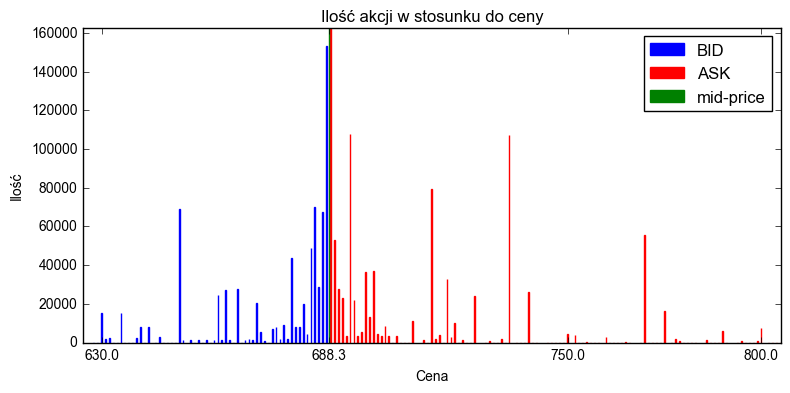

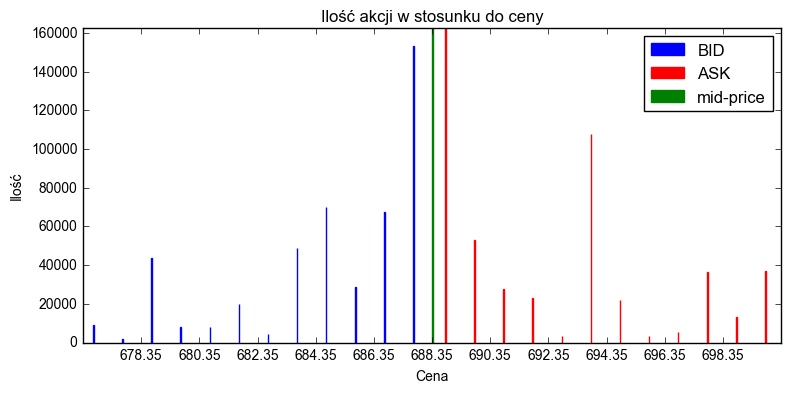

In [221]:
wiersz = tablicaTickowPo1[nrWiersza]
wierszWsp = np.array(tablicaTickowPo1Wsp[nrWiersza])
askMask = np.arange(0, len(wiersz), 2)
bidMask = askMask + 1
narysujPrzykladowyWykres(wierszWsp[askMask], wiersz[askMask],
                         wierszWsp[bidMask], wiersz[bidMask] * (-1),
                         midPrice, "PrzykladDanychDlaTablicyTickowPo1")

narysujPrzykladowyWykres(wierszWsp[askMask], wiersz[askMask],
                         wierszWsp[bidMask], wiersz[bidMask] * (-1),
                         midPrice, "PrzykladDanychDlaTablicyTickowPo1Przyblizenie", True)

In [451]:
tablica.shape

(4588, 4061)